## Load and Preprocess Data Manually

Since we are not using `ImageDataGenerator`, you need to load and preprocess images manually.

In [4]:
import os
import cv2
import numpy as np

# Define dataset path
DATASET_PATH = "datasets/asl_alphabet_train/asl_alphabet_train"
CLASSES = sorted(os.listdir(DATASET_PATH))  # 29 classes (A-Z, space, del, nothing)

# Image dimensions
IMG_SIZE = 64  # Resize to 64x64 pixels

# Lists to store images and labels
X, Y = [], []

# Load images and labels
for label, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)  # Read image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
        X.append(img)
        Y.append(label)  # Assign label to image

# Convert lists to NumPy arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize images
Y = np.array(Y, dtype=np.int64)  # Labels


✅ Now, X contains images, and Y contains corresponding labels (0 to 28).

### Split Data Into Training & Validation Sets

In [5]:
from sklearn.model_selection import train_test_split

# Split dataset (80% training, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


Training samples: 69600, Validation samples: 17400


### Build a Custom CNN Without TensorFlow

We'll use NumPy to manually implement convolutions, but for efficiency, I'll use PyTorch (optional) to handle automatic differentiation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2)  # Change shape to (N, C, H, W)
Y_train_tensor = torch.tensor(Y_train)

X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2)
Y_val_tensor = torch.tensor(Y_val)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define CNN Model (Custom Implementation)
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, 29)  # 29 output classes (A-Z, space, del, nothing)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No softmax (CrossEntropyLoss applies it)
        return x

# Initialize model, loss function, and optimizer
model = SignLanguageCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


✅Now, we have a PyTorch-based CNN instead of TensorFlow.

### Train the Model

In [7]:
# Training Loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")

print("Training Completed.")


Epoch 1, Loss: 3882.5235, Train Accuracy: 0.4136
Epoch 2, Loss: 1948.2937, Train Accuracy: 0.6735
Epoch 3, Loss: 1423.2544, Train Accuracy: 0.7578
Epoch 4, Loss: 1117.5907, Train Accuracy: 0.8087
Epoch 5, Loss: 913.8234, Train Accuracy: 0.8425
Epoch 6, Loss: 771.9869, Train Accuracy: 0.8650
Epoch 7, Loss: 680.0993, Train Accuracy: 0.8824
Epoch 8, Loss: 620.6251, Train Accuracy: 0.8926
Epoch 9, Loss: 555.7190, Train Accuracy: 0.9048
Epoch 10, Loss: 505.5767, Train Accuracy: 0.9129
Epoch 11, Loss: 469.4578, Train Accuracy: 0.9193
Epoch 12, Loss: 438.9894, Train Accuracy: 0.9255
Epoch 13, Loss: 402.8215, Train Accuracy: 0.9316
Epoch 14, Loss: 390.3055, Train Accuracy: 0.9349
Epoch 15, Loss: 371.6410, Train Accuracy: 0.9366
Epoch 16, Loss: 348.1646, Train Accuracy: 0.9401
Epoch 17, Loss: 332.7125, Train Accuracy: 0.9432
Epoch 18, Loss: 313.7227, Train Accuracy: 0.9475
Epoch 19, Loss: 304.1563, Train Accuracy: 0.9491
Epoch 20, Loss: 289.6449, Train Accuracy: 0.9516
Training Completed.


✅ Now, the CNN is trained without TensorFlow.

### Evaluate the Model

In [8]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()

val_acc = correct / len(val_loader.dataset)
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.9959


### Save & Use the Model

to save and use it for real-time sign detection:
```python
torch.save(model.state_dict(), "asl_sign_language_model.pth")
```
To load it later:
```python
model = SignLanguageCNN()
model.load_state_dict(torch.load("asl_sign_language_model.pth"))
model.eval()
```

In [9]:
torch.save(model.state_dict(), "asl_sign_language_model.pth")

We can generate a classification report, F1 scores, and other evaluation metrics using sklearn.metrics. Here's how:

### Evaluate Model on Test Data

#### Loading the model

In [10]:
import torch
import torch.nn as nn

# Define the model architecture (Must match the one used in training)
model = SignLanguageCNN()  # Replace with your actual model class
model.load_state_dict(torch.load("asl_sign_language_model.pth", map_location=torch.device('cpu')))
model.eval()  # Set model to evaluation mode


C:\Users\Imon\AppData\Local\Temp\ipykernel_16456\3112505039.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("asl_sign_language_model.pth

SignLanguageCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=29, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Loading the test dataset

In [14]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the same transformations as used during training
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Use the same normalization as training
])

# Load test dataset
test_dataset = ImageFolder(root='datasets/asl_alphabet_test/asl_alphabet_test', transform=transform)  # Replace with actual path
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = test_dataset.classes


#### Make Predictions

In [23]:
import numpy as np

y_true = []
y_pred = []
y_prob = []  # Store probabilities for AUC, Log Loss, ROC Curve

with torch.no_grad():
    for images, labels in test_loader:
        print("Test batch shape:", images.shape)  # Should be (batch_size, 3, 64, 64)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_prob.extend(probs.numpy())  # Store probabilities


Test batch shape: torch.Size([29, 3, 64, 64])


### Compute Matrices

In [16]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             mean_squared_error, log_loss, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  # Probabilities for AUC, Log Loss

#### Accuracy

In [17]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3103


#### Precision, Recall, F1-Score

In [18]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.1925
Recall: 0.3103
F1 Score: 0.2190


d:\ASL\ASL_DETECTION\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

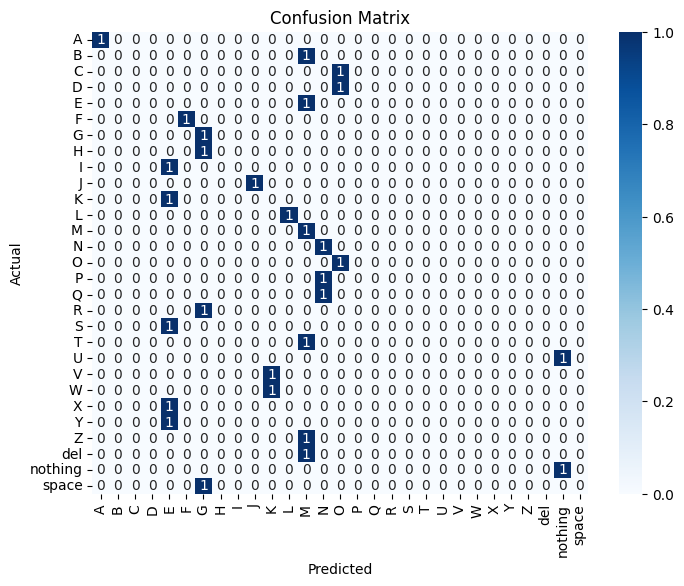

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### AUC (One-vs-Rest approach for multi-class)

In [20]:
auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
print(f"AUC: {auc:.4f}")

AUC: 0.7666


#### Mean Squared Error & RMSE

In [21]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

MSE: 96.7586
RMSE: 9.8366


#### Log loss

In [22]:
# Log Loss
logloss = log_loss(y_true, y_prob)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 10.4690


d:\ASL\ASL_DETECTION\.venv\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


#### ROC Curve (One-vs-Rest for multi-class)

y_true shape: (29,)
y_prob shape: (29, 29)


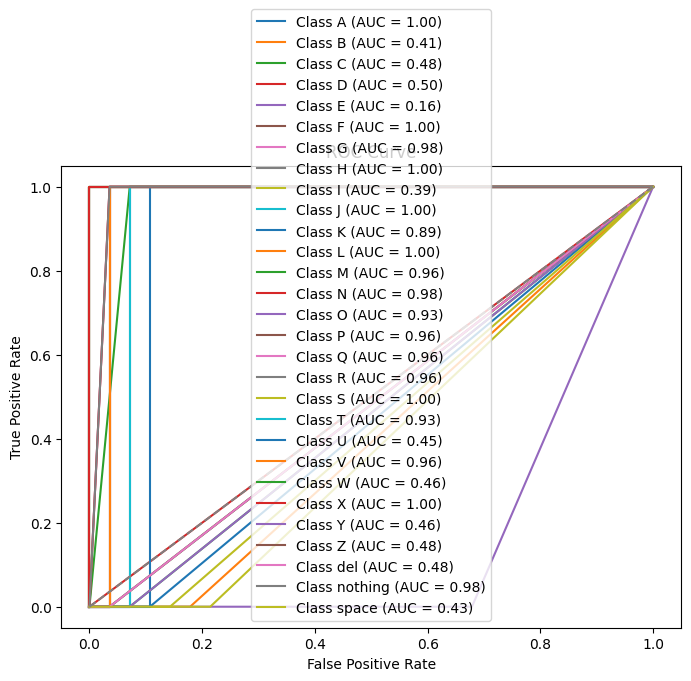

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ensure y_true and y_prob are NumPy arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Debugging check
print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

plt.figure(figsize=(8,6))
for i in range(len(class_names)):  # For each class
    fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])  # Fix applied
    auc_score = roc_auc_score(y_true == i, y_prob[:, i])  # Fix applied
    
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

